In [36]:
import os
import math
import scipy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.graphics.gofplots import qqplot

import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

In [2]:
base_dir=r'D:\kaggle\customer segmentation'
os.chdir(base_dir)
df_org = pd.read_excel('Online Retail.xlsx')

In [44]:
df=df_org.copy()

In [45]:
print(df.isna().sum()) # CustomerID contains null, drop
# Quantity and UnitPrice contain neg values
print('There are {0} records have neg Quantity value and {1} records have neg Price.'.format(len(df[df['Quantity']<0]), len(df[df['UnitPrice']<0])))

df = df[(~df['CustomerID'].isna())&(df['Quantity']>0)&(df['UnitPrice']>0)] # remove records contain neg Quantity or neg price

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
There are 10624 records have neg Quantity value and 2 records have neg Price.


In [46]:
df.drop_duplicates(inplace=True)

In [47]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.0+ MB


,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4338 non-null   int64  
 1   Frequency      4338 non-null   int64  
 2   MonetaryValue  4338 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 135.6 KB
None
           Recency    Frequency  MonetaryValue
count  4338.000000  4338.000000    4338.000000
mean     93.059474    90.523744    2048.688081
std     100.012264   225.506968    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     306.482500
50%      51.000000    41.000000     668.570000
75%     142.750000    98.000000    1660.597500
max     374.000000  7676.000000  280206.020000
Recency          0
Frequency        0
MonetaryValue    0
dtype: int64


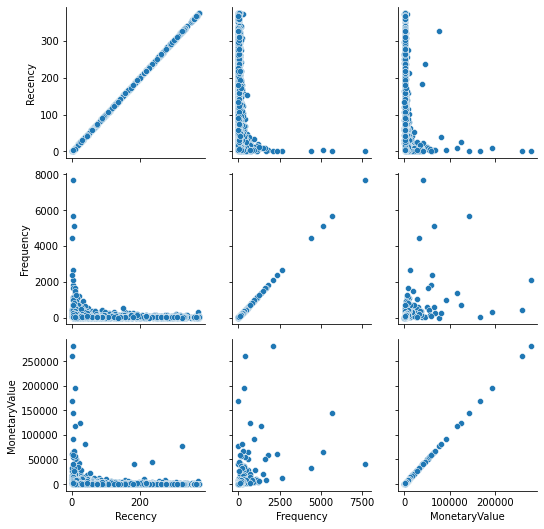

In [48]:
# Follow MFM model
# for each customer, get the most recent inovice date as the recency
#                        the number of buying as frequency, 
#                        the total sum as monetary value.
df['TotalSum']=df['Quantity']*df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
# date time to date
latest_day = max(df['InvoiceDate'] ) + datetime.timedelta(days=1)

df_customers = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (latest_day-x.max()).days,
    'InvoiceNo':'count',
    'TotalSum':'sum'})



df_customers.rename(columns={'InvoiceDate': 'Recency',
                             'InvoiceNo': 'Frequency',
                             'TotalSum': 'MonetaryValue'}, inplace=True)

print(df_customers.info())
print(df_customers.describe())
print(df_customers.isnull().sum())

g=sns.PairGrid(df_customers)
g.map(sns.scatterplot)

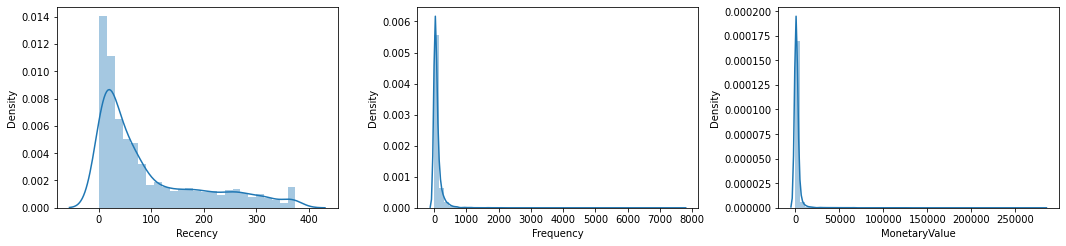

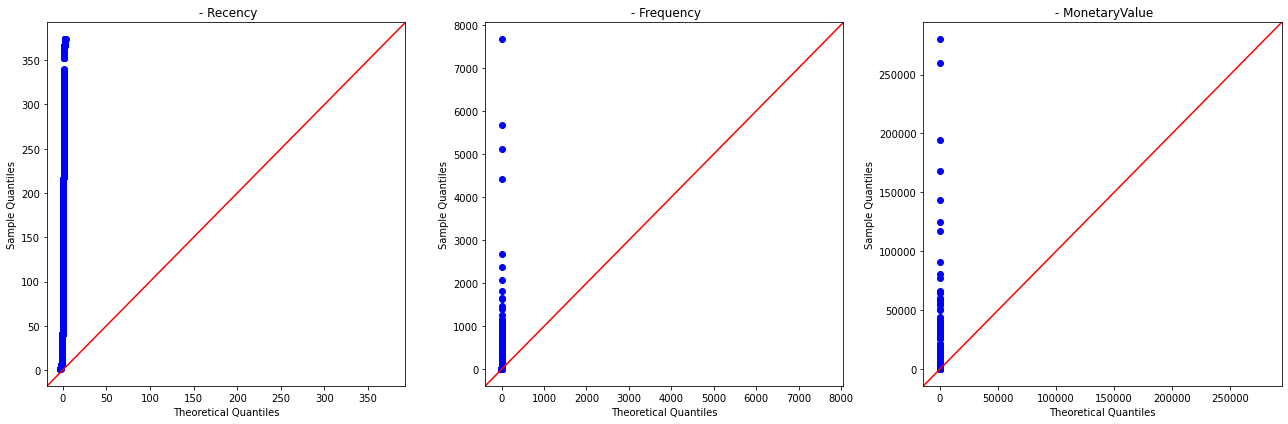

In [49]:
def show_dist(df, title=''):
    cols = [i for i in df.columns]
    plt.figure(figsize = [15, 10])
    
    for c in range(len(cols)):
        plt.subplot(3,3,c+1)
        plt.suptitle(title, size=16)
        sns.distplot(df[cols[c]])
    plt.tight_layout()
    plt.show()
    return

def show_qqplots(df, title=''):
    cols = [i for i in df.columns]
    fig = plt.figure(figsize=(18,6))
    ax1 = fig.add_subplot(1, 3, 1)
    qqplot(df[cols[0]], line='45', ax=ax1)
    ax1.title.set_text('{0} - {1}'.format(title, cols[0]))
    ax2 = fig.add_subplot(1, 3, 2)
    qqplot(df[cols[1]], line='45',ax=ax2)
    ax2.title.set_text('{0} - {1}'.format(title, cols[1]))
    ax3 = fig.add_subplot(1, 3, 3)
    qqplot(df[cols[2]], line='45',ax=ax3)
    ax3.title.set_text('{0} - {1}'.format(title, cols[2]))
    fig.tight_layout()
    plt.gcf()
    return 

show_dist(df_customers)
show_qqplots(df_customers)

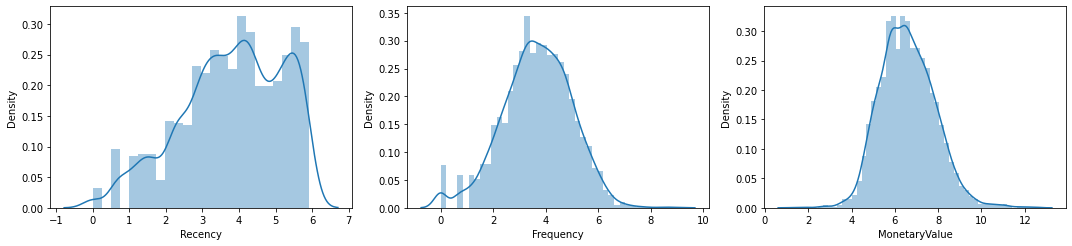

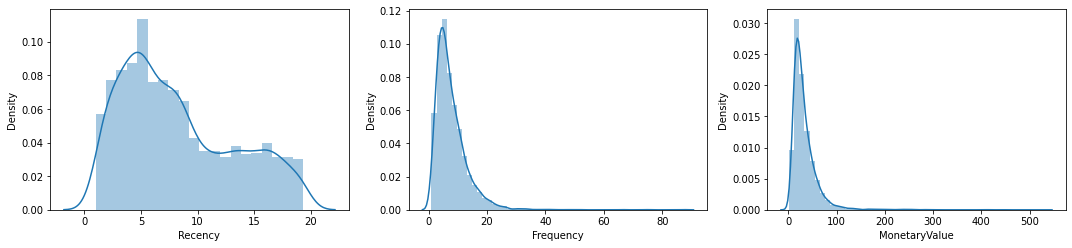

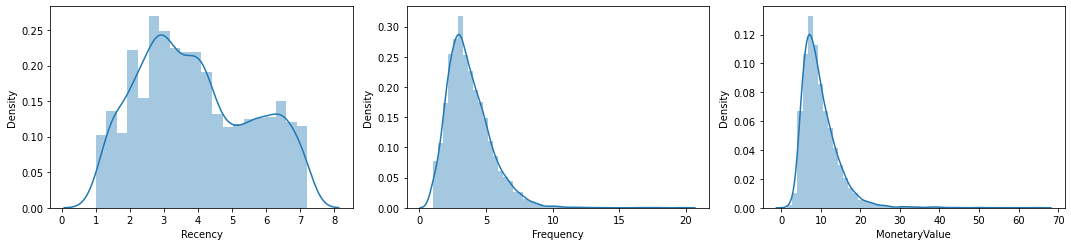

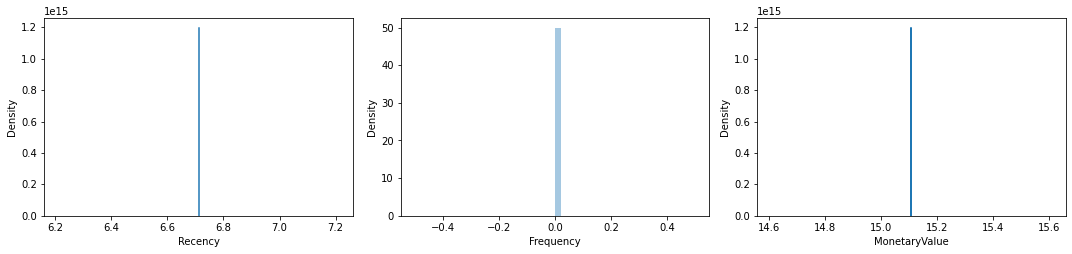

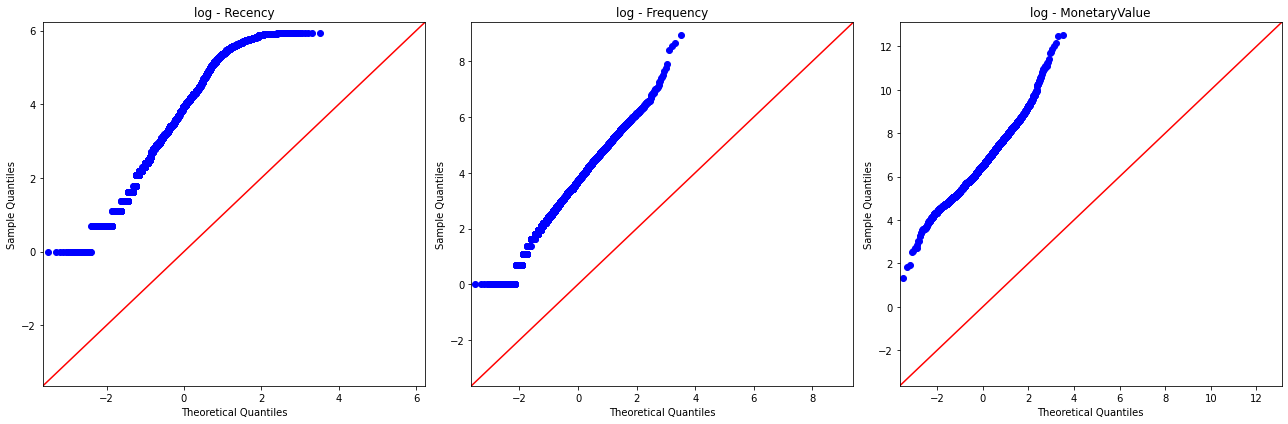

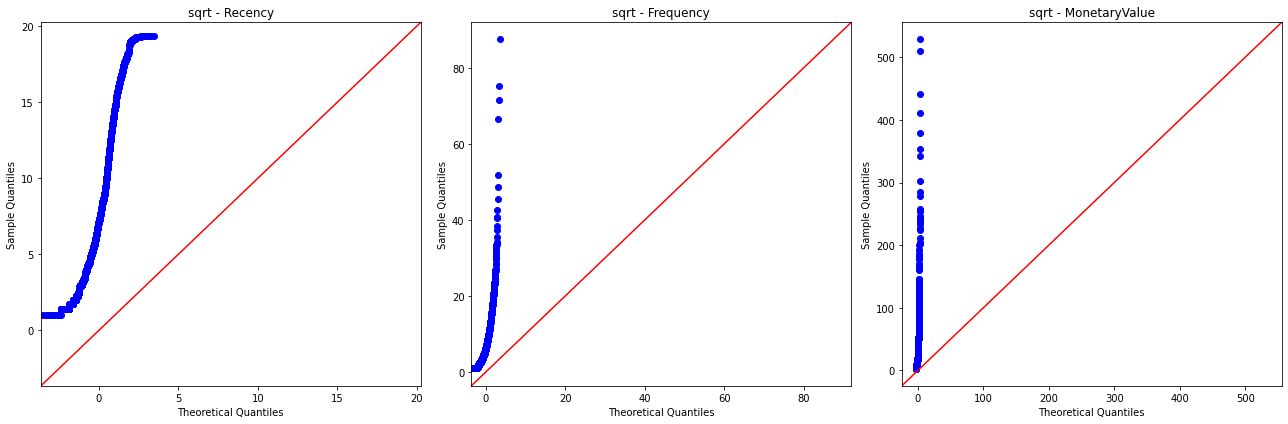

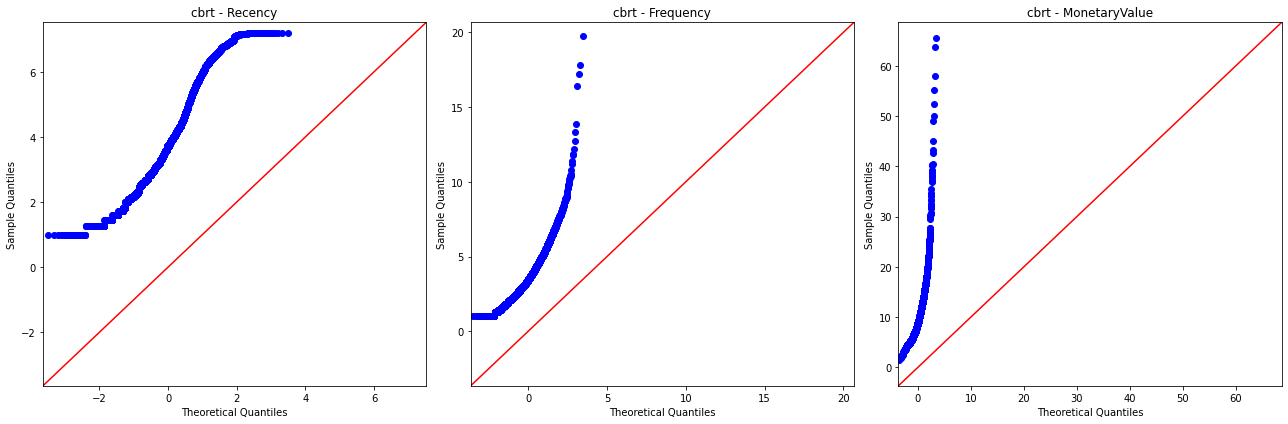

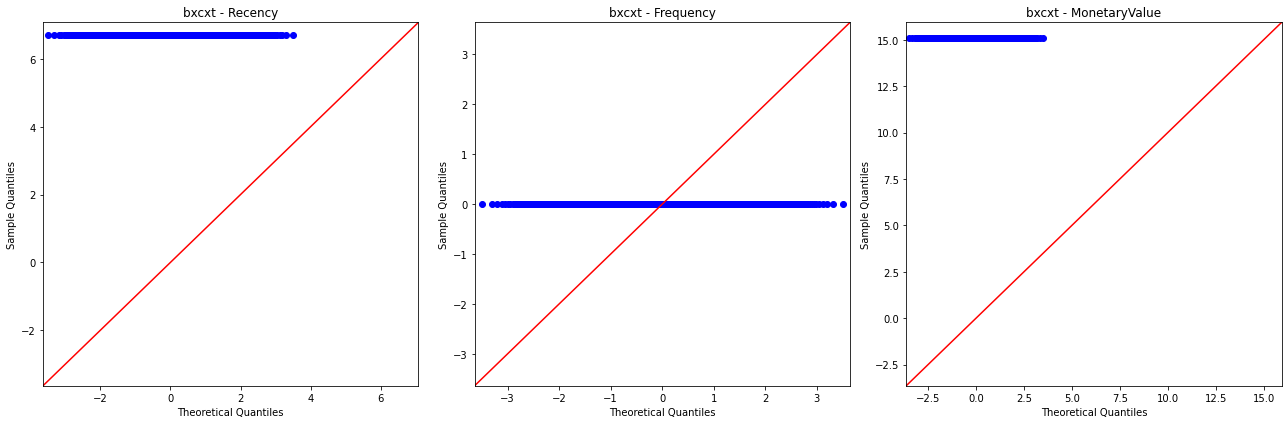

In [50]:
cols = [i for i in df_customers.columns]
cutomers_logT = df_customers.copy(deep=True) # logist  
cutomers_sqrtT = df_customers.copy(deep=True) # square root
cutomers_cbrtT = df_customers.copy(deep=True) # cube-root 
cutomers_bxcxT = df_customers.copy(deep=True) # Box-Cox power transformation, when lmbda = 0, equal to logT

for c in cols:
    cutomers_logT[c] = np.log(df_customers[c]).apply(lambda x: np.nan if x == float('-inf') else x)
    cutomers_sqrtT[c] = np.sqrt(df_customers[c])
    cutomers_cbrtT[c] = np.cbrt(df_customers[c])
    cutomers_bxcxT[c] = stats.boxcox(df_customers[c], lmbda=.05)[0]

show_dist(cutomers_logT,)
show_dist(cutomers_sqrtT)
show_dist(cutomers_cbrtT)
show_dist(cutomers_bxcxT)
show_qqplots(cutomers_logT,'log')
show_qqplots(cutomers_sqrtT,'sqrt')
show_qqplots(cutomers_cbrtT,'cbrt')
show_qqplots(cutomers_bxcxT,'bxcxt')
# still not follow normal distribution

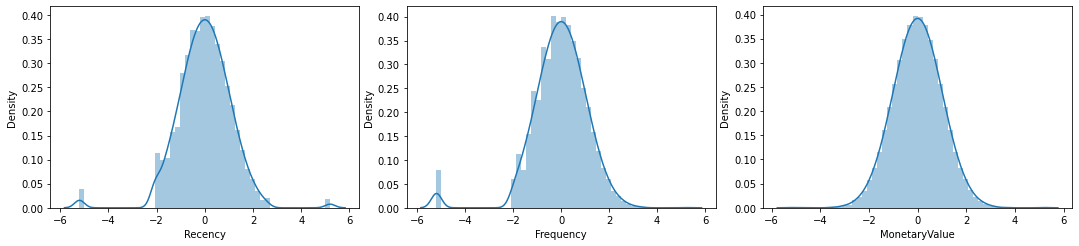

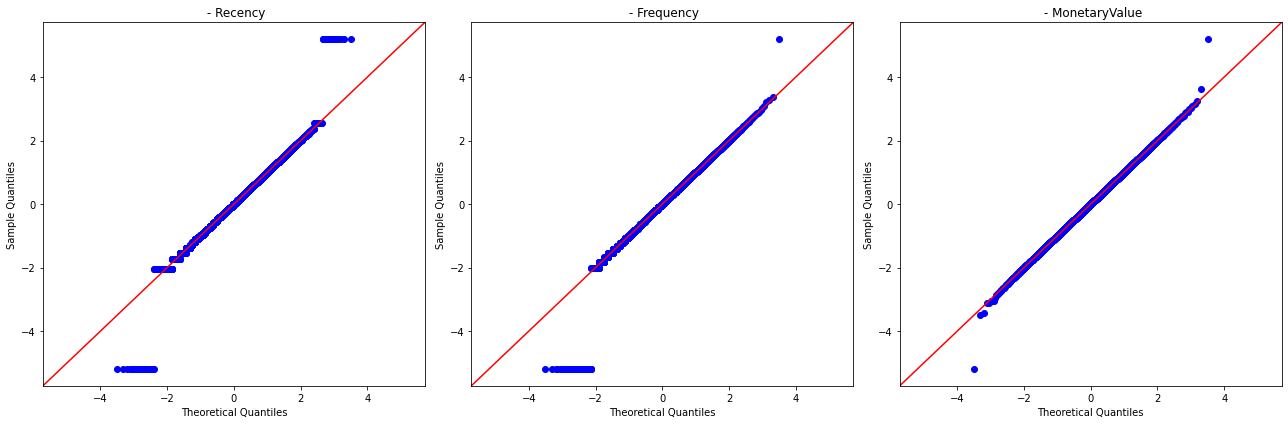

In [51]:
# still not follow normal distribution

# normal trasformation
from sklearn import preprocessing
q_transformer = preprocessing.QuantileTransformer(output_distribution='normal')
c_f = q_transformer.fit_transform(df_customers)
dfc = pd.DataFrame(c_f)
dfc.rename(columns = {0:'Recency',
                      1:'Frequency',
                      2:'MonetaryValue'}, inplace=True)


show_dist(dfc)
show_qqplots(dfc)

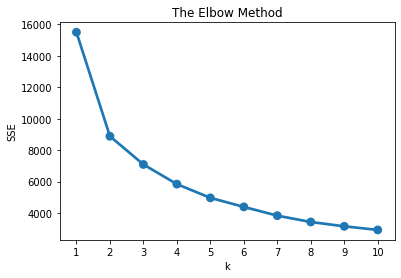

In [52]:
# k-means
# elbow
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dfc)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

#Elbow Plot    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [53]:
model = KMeans(n_clusters=5)
model.fit(dfc)
dfc['label']=model.labels_

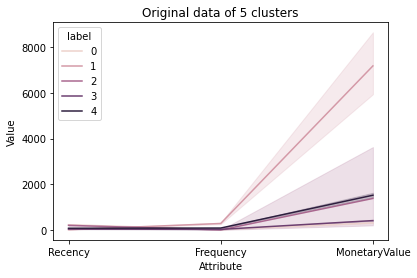

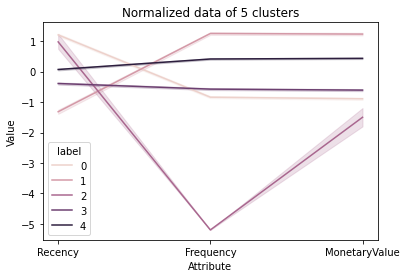

In [54]:
df1 = df_customers.copy(deep=True)
df1['label']=model.labels_

df2 = df1.groupby('label').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)
df2

# original data
df3 = pd.melt(df1.reset_index(), id_vars=['label'], 
              value_vars=['Recency','Frequency','MonetaryValue'],
              var_name='Attribute',value_name='Value')
sns.lineplot('Attribute', 'Value', hue='label', data=df3)
plt.title('Original data of 5 clusters')
plt.show()
# normalized data
df4 = pd.melt(dfc.reset_index(), id_vars=['label'], 
              value_vars=['Recency','Frequency','MonetaryValue'],
              var_name='Attribute',value_name='Value')
sns.lineplot('Attribute', 'Value', hue='label', data=df4)
plt.title('Normalized data of 5 clusters')
plt.show()

In [55]:
filename = 'KMeans_customer_seg.sav'
pickle.dump(model, open(filename, 'wb'))

In [61]:
loaded_model = pickle.load(open(filename, 'rb'))
#pred_label = loaded_model.predict(X)